In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from amb_scripts.load_saved_info import *
from amb_scripts.plot_csfv3 import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *
from dag_prf_utils.utils import *
from dag_prf_utils.mesh_maker import *

plot_cols = get_plot_cols()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [5]:
sub_list = ['sub-01', 'sub-02']
ses_list = ['ses-1', 'ses-2']
qCSF_info = {}
for sub in sub_list:
    qCSF_info[sub] = {}
    for ses in ses_list:
        qCSF_info[sub][ses] = amb_load_qcsf(sub, eye_list=['L', 'R'], ses=ses)


In [6]:
roi_fit = 'all'
fit_stage='iter'

model_list = ['gauss', 'csf']#, 'css', 'dog', 'norm']
prf_multi = {}

for sub in sub_list:
    prf_obj_list = [] 
    prf_id_list = []
    for i_ses,ses in enumerate(ses_list):        
        for eye in ['L', 'R']:    
            for model in model_list:
                if 'csf' in model:
                    task = f'CSF{eye}E'
                    # roi_fit = 'all'
                else:
                    task = f'pRF{eye}E'
                    # roi_fit = 'all'

                this_prf_data = amb_load_prf_params(
                    sub=sub,
                    task_list=task,
                    model_list=model,
                    roi_fit=roi_fit, 
                    fit_stage=fit_stage,
                    ses=ses
                )[task][model]
                                                        
                prf_obj_list.append(Prf1T1M(this_prf_data, model))
                prf_id_list.append(f'{eye}_{i_ses+1}_{model}')   
            
    prf_multi[sub] = PrfMulti(prf_obj_list, prf_id_list)

In [7]:
# Add AREA UN LOG CSF
# load prfpy stim

m = 'csf'
for sub in sub_list:
    prf_obj_list = [] 
    prf_id_list = []
    for ses in ['1', '2']:        
        for eye in ['L', 'R']:    
            task = f'CSF{eye}E'
            # this_AULCSF = add_aulcsf_to_objV2(
            #     prf_obj=prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'],
                
            # )
            this_AULCSF = add_aulcsf_to_objV2(
                prf_obj=prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'],
                
            )            
            prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].pd_params['AULCSF'] = this_AULCSF.copy()
            # sys.exit()

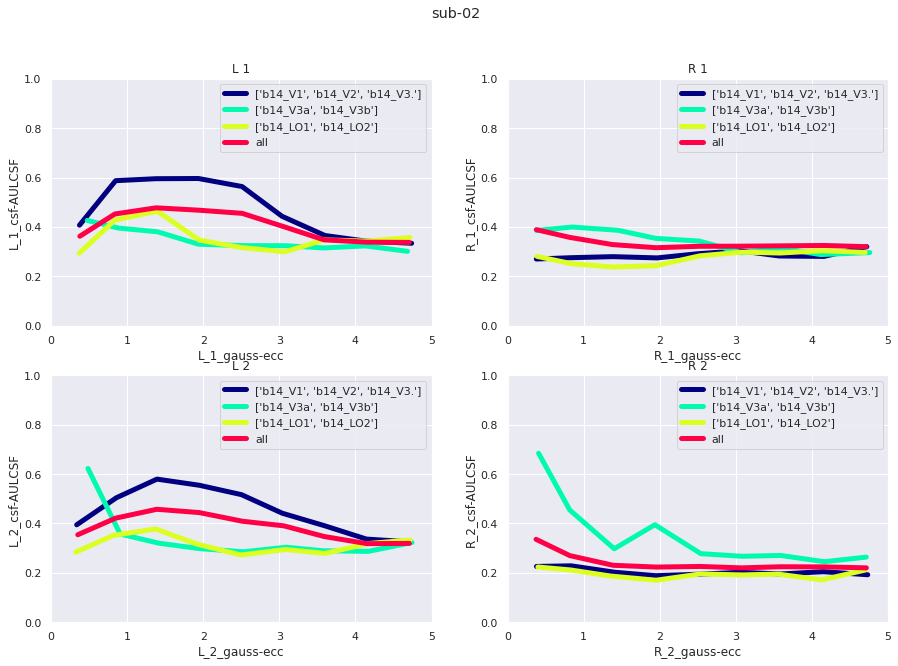

In [44]:
sns.set_theme()
# sns.set_context('paper')
y_param = 'csf-AULCSF'
y_lim = [0,1]
roi_list = [['b14_V1', 'b14_V2', 'b14_V3.'], ['b14_V3a', 'b14_V3b'], ['b14_LO1', 'b14_LO2'], 'all']
for sub in sub_list[1::]:
    fig,ax = plt.subplots(2,2)
    fig.set_size_inches(15,10)
    fig.suptitle(sub)

    for i,roi in enumerate(roi_list):
        this_col = dag_get_col_vals(i, cmap='gist_ncar', vmin=0, vmax=len(roi_list))
        roi_mask = amb_load_roi(sub, roi)

        for i_ses, ses in enumerate(['1','2']):
            for i_eye, eye in enumerate(['L', 'R']):
                # print(ses)
                # print(roi)
                prf_multi[sub].scatter(
                    px=f'{eye}_{ses}_gauss-ecc',
                    py=f'{eye}_{ses}_{y_param}',
                    do_line=True,
                    bins=np.linspace(0,5,10),
                    do_scatter=False,
                    ax=ax[i_ses, i_eye],
                    line_label=roi,
                    th_plus={'roi':roi_mask},
                    line_col = this_col,
                    x_lim=[0,5],
                    y_lim=y_lim,
                    do_bars=False,

                )
                ax[i_ses, i_eye].set_title(f'{eye} {ses}')

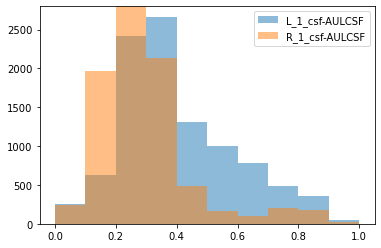

In [62]:
sub = 'sub-02'
roi_mask = amb_load_roi(sub, 'all')
th={
    'L_1_csf-min-rsq':.1, 
    # 'L_2_csf-min-rsq':.1, 
    'R_1_csf-min-rsq':.1, 
    # 'R_2_csf-min-rsq':.1, 
    #
    'L_1_gauss-bound-ecc':[0,50], 
    # 'L_2_gauss-bound-ecc':[0,5], 
    'R_1_gauss-bound-ecc':[0,50], 
    # 'R_2_gauss-bound-ecc':[0,5], 

    'roi':roi_mask
    }
prf_multi[sub].hist(px='L_1_csf-AULCSF', th=th, alpha=0.5)
prf_multi[sub].hist(px='R_1_csf-AULCSF', th=th, alpha=0.5, ax=plt.gca())

In [262]:
for sub in sub_list:
    # prf_multi[sub].add_prf_diff('L_1_gauss', 'L_2_gauss', new_id='diff_L12')
    # prf_multi[sub].add_prf_diff('R_1_gauss', 'R_2_gauss', new_id='diff_R12')
    # prf_multi[sub].add_prf_diff('L_1_gauss', 'R_1_gauss', new_id='diff_L1R1')
    # prf_multi[sub].add_prf_diff('L_2_gauss', 'R_2_gauss', new_id='diff_L2R2')    


    prf_multi[sub].add_prf_diff('L_1_gauss', 'L_2_gauss', new_id='diff_L12g')
    prf_multi[sub].add_prf_diff('R_1_gauss', 'R_2_gauss', new_id='diff_R12g')
    prf_multi[sub].add_prf_diff('L_1_gauss', 'R_1_gauss', new_id='diff_L1R1g')
    prf_multi[sub].add_prf_diff('L_2_gauss', 'R_2_gauss', new_id='diff_L2R2g')        

    prf_multi[sub].add_prf_diff('L_1_csf', 'L_2_csf', new_id='diff_L12c')
    prf_multi[sub].add_prf_diff('R_1_csf', 'R_2_csf', new_id='diff_R12c')
    prf_multi[sub].add_prf_diff('L_1_csf', 'R_1_csf', new_id='diff_L1R1c')
    prf_multi[sub].add_prf_diff('L_2_csf', 'R_2_csf', new_id='diff_L2R2c')        

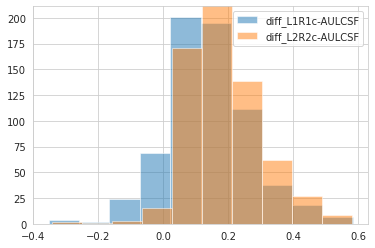

In [263]:
roi_mask = amb_load_roi(sub, 'b14_V1')
th={
    'L_1_csf-min-rsq':.1, 
    'L_2_csf-min-rsq':.1, 
    'R_1_csf-min-rsq':.1, 
    'R_2_csf-min-rsq':.1, 
    #
    # 'R_1_gauss-bound-ecc':[0,5], 
    # 'R_2_gauss-bound-ecc':[0,5], 
    # 'L_1_gauss-bound-ecc':[0,5], 
    # 'L_2_gauss-bound-ecc':[0,5], 

    'roi':roi_mask
    }

prf_multi[sub].rapid_hist(
    ax=plt.gca(), px='diff_L1R1c-AULCSF', alpha=0.5, th=th,#bins=np.linspace(-2,2,10),
)
prf_multi[sub].rapid_hist(
    ax=plt.gca(), px='diff_L2R2c-AULCSF', alpha=0.5, th=th,#bins=np.linspace(-2,2,10),
)
# ax = plt.gca()
# ax.set_xlim(-8,8)
# ax.set_ylim(-8,8)
# ax.plot((0,0), (-8,8), 'k')
# ax.plot((-8,8), (0,0), 'k')
# ax.set_aspect('equal')

In [ ]:
roi_mask = amb_load_roi(sub, 'b14_V1')
th={
    'L_1_csf-min-rsq':.1, 
    'L_2_csf-min-rsq':.1, 
    'R_1_csf-min-rsq':.1, 
    'R_2_csf-min-rsq':.1, 
    #
    # 'R_1_gauss-bound-ecc':[0,5], 
    # 'R_2_gauss-bound-ecc':[0,5], 
    # 'L_1_gauss-bound-ecc':[0,5], 
    # 'L_2_gauss-bound-ecc':[0,5], 

    'roi':roi_mask
    }

prf_multi[sub].rapid_hist(
    ax=plt.gca(), px='diff_L1R1c-AULCSF', alpha=0.5, th=th,#bins=np.linspace(-2,2,10),
)
prf_multi[sub].rapid_hist(
    ax=plt.gca(), px='diff_L2R2c-AULCSF', alpha=0.5, th=th,#bins=np.linspace(-2,2,10),
)
# ax = plt.gca()
# ax.set_xlim(-8,8)
# ax.set_ylim(-8,8)
# ax.plot((0,0), (-8,8), 'k')
# ax.plot((-8,8), (0,0), 'k')
# ax.set_aspect('equal')

In [256]:
amb_load_roi(sub, 'occ').sum()

108077

In [257]:
roi_mask = amb_load_roi(sub, 'all')
th={
    'L_1_gauss-min-rsq':.1, 
    'L_2_gauss-min-rsq':.1, 
    'R_1_gauss-min-rsq':.1, 
    'R_2_gauss-min-rsq':.1, 
    #
    'R_1_gauss-bound-ecc':[0,5], 
    'R_2_gauss-bound-ecc':[0,5], 
    'L_1_gauss-bound-ecc':[0,5], 
    'L_2_gauss-bound-ecc':[0,5], 

    'roi':roi_mask
    }
p_list = ['diff_L1R1-size_1', 'diff_L2R2-size_1']    
pd2plot = pd.DataFrame(prf_multi[sub].return_th_params(p_list, th, th_plus={'roi':roi_mask}))
dag_full_violin(pd2plot) 
# plt.gca().set_title(f'{m} {sub}')
# plt.gca().set_ylabel(p)
plt.gca().set_xlabel('session')
# plt.gca().legend(['Left', 'Right'])
# plt.gca().set_ylim(vval_dict[p])
plt.gcf().set_size_inches(10,10)
dag_update_ax_fontsize(plt.gca(), 20)


KeyError: 'diff_L1R1'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


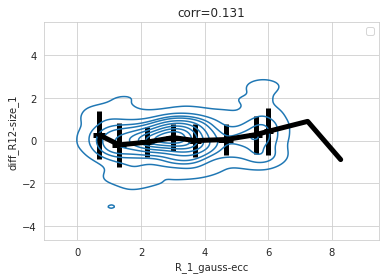

In [174]:
roi_mask = amb_load_roi(sub, 'b14_V1')
prf_multi[sub].rapid_p_corr(
    py='diff_R12-size_1', px='R_1_gauss-ecc', th={'R_1_gauss-min-rsq':.2, 'R_2_gauss-min-rsq':.2, 'roi':roi_mask}, do_kde=True, do_scatter=False, do_line=True
)

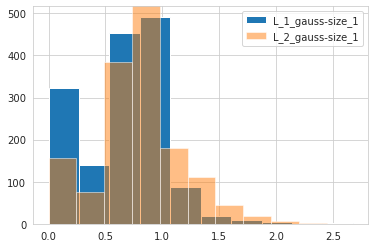

In [195]:
roi_mask = amb_load_roi(sub, 'b14_V1')
th={
    'R_1_gauss-min-rsq':.1, 
    'R_2_gauss-min-rsq':.1, 
    'R_1_gauss-bound-ecc':[0,300], 
    'R_2_gauss-bound-ecc':[0,300], 
    'R_1_gauss-bound-size_1':[0,3], 
    'R_2_gauss-bound-size_1':[0,3],     
    'roi':roi_mask
    }

prf_multi[sub].rapid_hist(
    px='L_1_gauss-size_1', 
    th=th,
)

prf_multi[sub].rapid_hist(
    px='L_2_gauss-size_1',  
    th=th,
    ax=plt.gca(),alpha=0.5

)

# qCSF plots

In [7]:
# # qCSF 
# p_label = ['peakCS', 'peakSF', 'bdwth', 'lowSFtrunc', 'AULCSF']
# for sub in sub_list:
#     print(sub)
#     for eye in ['L', 'R']:    
#         # print(f'Eye = {eye}')
#         for ses in ses_list:
#             # print(f'{ses}')
#             p_list = ''
#             for p in p_label:

#                 # print(f'{p:>10} = {qCSF_info[sub][ses][eye][p]:.3f}')
#                 p_list += f' {qCSF_info[sub][ses][eye][p]:.3f}'
#                 # qCSF_info['L'].keys()
#             print(p_list)
#     print('')

# # Compare CSFs: *  general
# # SFs = qCSF_info['L']['SF_list']
# fig_path = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/reports/'

# SFs = np.linspace(.25, 30, 100)
# # [1] qCSF L & R
# for sub in sub_list:
#     for ses in ses_list:
#         plt.figure()
#         plt.title(f'{sub}-{ses}-beh')
#         for eye in ['L', 'R']:
#             b_log_csf = qcsf_curve(
#                 SFs,
#                 qCSF_info[sub][ses][eye]['peakCS'],
#                 qCSF_info[sub][ses][eye]['peakSF'],
#                 qCSF_info[sub][ses][eye]['bdwth'],
#                 qCSF_info[sub][ses][eye]['lowSFtrunc'],
#             )
#             if eye=='L':
#                 col ='r'
#             else:
#                 col='b'
#             plt.plot(np.log10(SFs), b_log_csf, color=col, marker='*', label=f'{eye}')
#             # Also plot max
#             ylim = (0,2.5)
#             this_peakSF = qCSF_info[sub][ses][eye]['peakSF']
#             plt.plot((this_peakSF,this_peakSF), ylim, color=col)
#             plt.legend()

#         plt.savefig(opj(fig_path, f'{sub}_violin', f'qCSF-{sub}-{ses}.svg'))
#         plt.savefig(opj(fig_path, f'{sub}_violin', f'qCSF-{sub}-{ses}.png'))



# violin plots: all

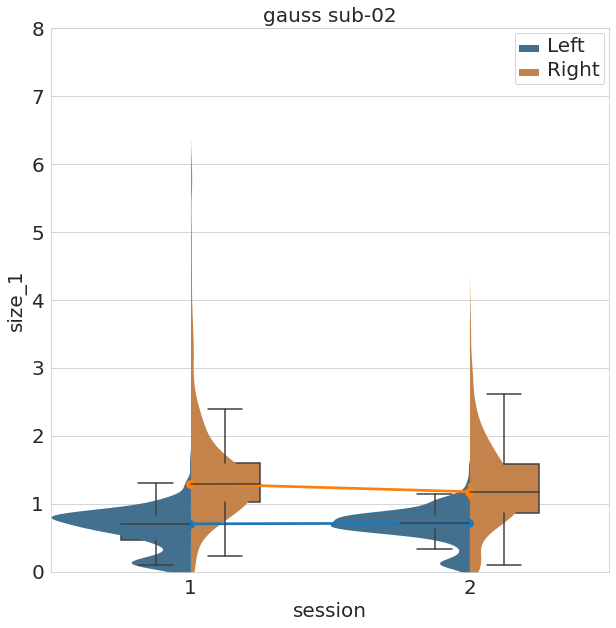

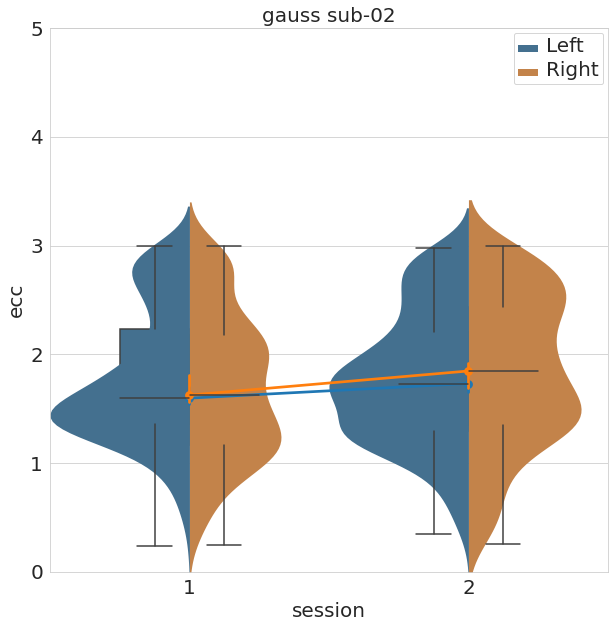

In [130]:
p_list = {
    'gauss' : ['size_1', 'ecc'], #['ecc',  'size_1', 'rsq'],
    # 'csf' : ['AULCSF', 'rsq'] #['width_r', 'sf0', 'maxC', 'sfmax', 'rsq']
}    
vval_dict = {
    'pol': [-3.14, 3.14],
    'ecc': [0,5],
    'size_1': [0,8],
    'rsq': [0,1],
    'width_r': [0,3],
    'sf0' : [0,6],
    'maxC': [0, 200],
    'sfmax': [0, 20],
    'AULCSF': [0,1],
    }

roi = 'b14_V1'    

for sub in sub_list:
    roi_mask = amb_load_roi(sub, roi)
    for m in p_list.keys():
        if m=='csf':
            th = {'min-rsq':.1}
        else:
            th = {'min-rsq':.1, 'max-ecc':5}

        for p in p_list[m]:
            plt.figure()
            task_list = ['L_1', 'L_2', 'R_1', 'R_2']            
            p_list = [f'{i}_{m}-{p}' for i in task_list]
            c_list = [f'{i}_{m}' for i in task_list]            
            th ={}            
            for c in c_list:
                th[f'{c}-min-rsq'] = .1
                if m!='csf':
                    th[f'{c}-bound-ecc'] = [0,3]
            
            pd2plot = pd.DataFrame(prf_multi[sub].return_th_params(p_list, th, th_plus={'roi':roi_mask}))
            dag_half_violin(pd2plot, split_id=['L', 'R'], match_id=['1', '2']) 
            plt.gca().set_title(f'{m} {sub}')
            plt.gca().set_ylabel(p)
            plt.gca().set_xlabel('session')
            plt.gca().legend(['Left', '_', 'Right'])
            plt.gca().set_ylim(vval_dict[p])
            plt.gcf().set_size_inches(10,10)
            dag_update_ax_fontsize(plt.gca(), 20)
            

            # plt.figure()    
            # plt.gcf().suptitle(f'{sub} {m} {p}')
            # plt.gca().set_ylim(vval_dict[p])
            # plt.gcf().set_size_inches(10,10)
            # plt.gcf().set_tight_layout('tight')
            # dag_update_fig_fontsize(plt.gcf(), 30)


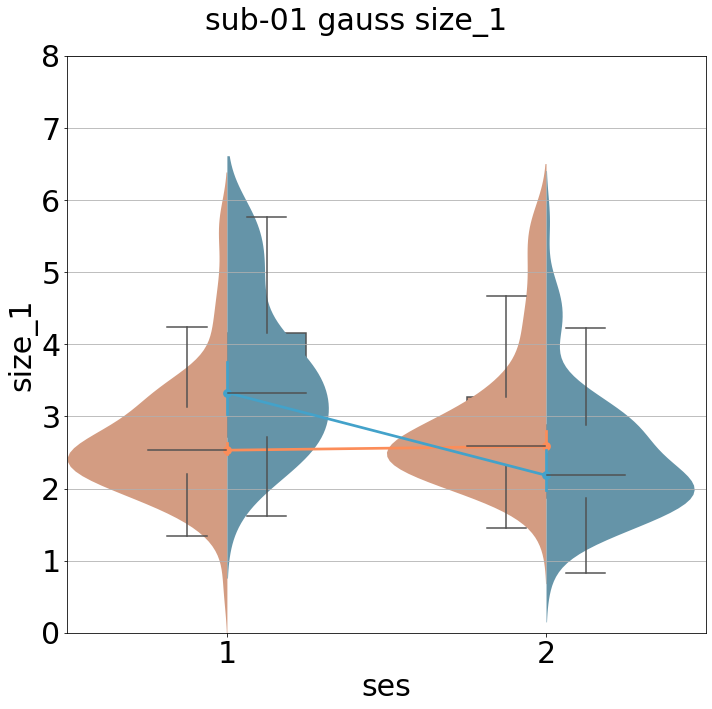

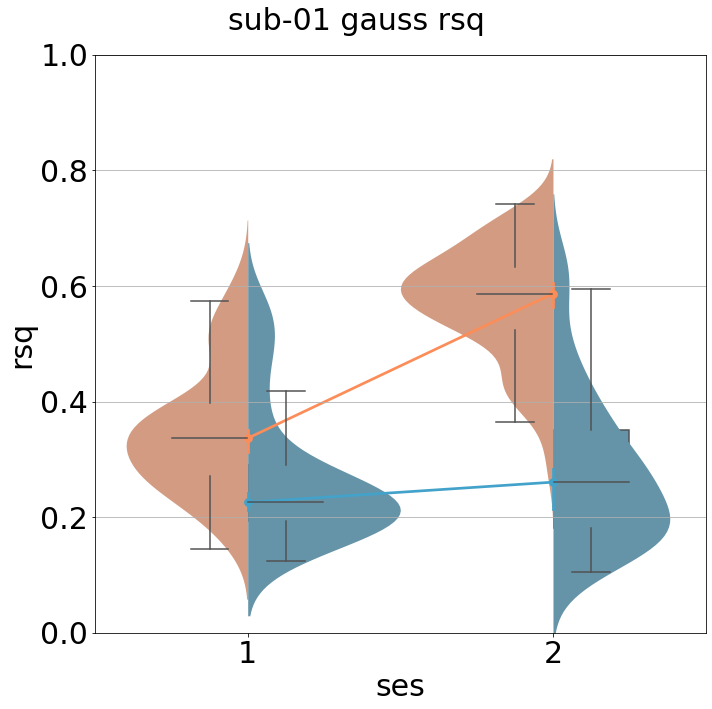

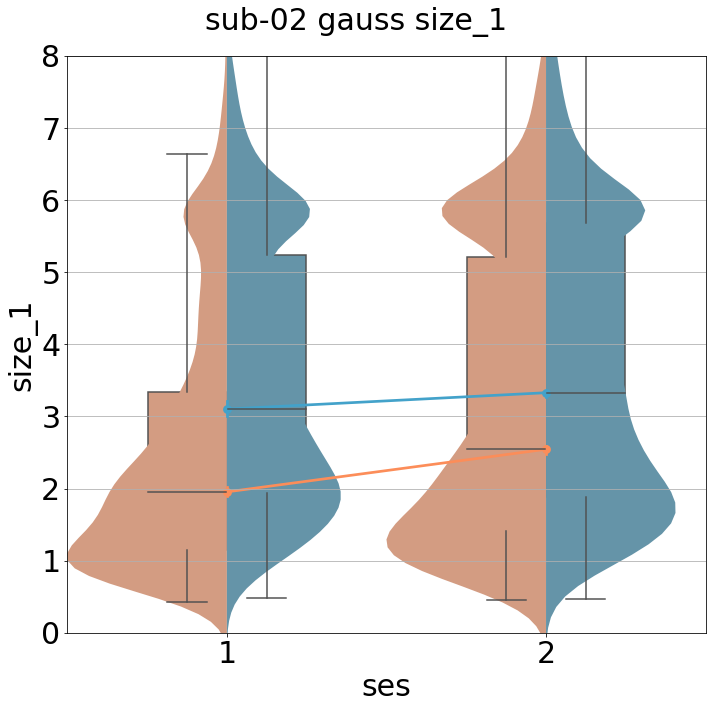

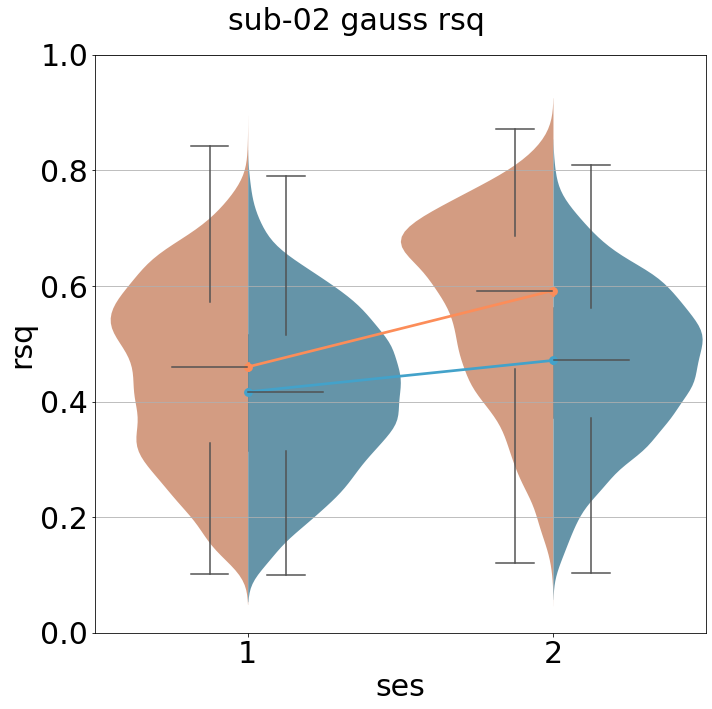

In [64]:

# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

def LE_RE_ses_violin(prf_multi, model, param, th=None, do_plot=True,do_matched=True, ):        
    if th is None:
        th = {'min-rsq':.1, 'max-ecc':5}
    # prfx = Prf1T1Mx2(prf_obj1=prfL, prf_obj2=prfR, id1='L', id2='R')
    if do_matched:
        vx_mask = prf_multi.return_vx_mask(th)
    p_dict = {}
    p_dict[param] = []
    p_dict['eye'] = []
    p_dict['ses'] = []
    if do_matched:
        p_dict['vx_id'] = []
    # p_dict['model'] = []
    for eye in ['L', 'R']:
        for ses in ['1', '2']:
            if do_matched:
                this_vx_mask = vx_mask
            else:
                this_vx_mask = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].return_vx_mask(th)
            this_p = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].pd_params[param][this_vx_mask]
            p_dict[param].append(this_p)
            p_dict['eye'].append([eye]*len(this_p))
            p_dict['ses'].append([ses]*len(this_p))
            if do_matched:
                p_dict['vx_id'].append(np.arange(len(this_p)))

    for key in p_dict.keys():                                                              
        p_dict[key] = np.concatenate(p_dict[key])                                          
    p_PD = pd.DataFrame(p_dict) 
    # if do_matched:
    #     formula = f'{param} ~ C(eye) + C(ses) + C(eye):C(ses)'
    #     model = ols(formula, data=p_PD).fit()
    #     anova_table = sm.stats.anova_lm(model, typ=2)
    #     print(anova_table)   
    # else:

    if do_plot:                                                        
        sns.violinplot(                                                                        
            x="ses", y=param, hue="eye",                                
            data=p_PD, palette=[plot_cols["LE"], plot_cols["RE"]],                     
            width=1, linewidth=0, split=True, inner=None,saturation=0.5)                                     
        sns.boxplot(x="ses", y=param,                                            
                    hue="eye", palette=[plot_cols["LE"], plot_cols["RE"]],        
                    data=p_PD, showfliers = False, width=.5, saturation=0.5)
        sns.pointplot(
            x="ses", y=param, 
            hue="eye", palette=[plot_cols["LE"], plot_cols["RE"]],        
            estimator=np.median,
            data=p_PD)                               
        # # sns.despine(offset=10, trim=True)                                                    
        plt.gca().grid(True, which='both', axis="y")  
        plt.gca().get_legend().remove()



        # # plt.legend('off')                                         
        # plt.gca().set_ylim(0,5)                                                               
        # plt.gca().set_title(title)                                                               
        # y_max = plt.gca().get_ylim()[-1]
        # plt.gcf().set_size_inches(10,4)
        # dag_update_ax_fontsize(plt.gca(), 15)
        # for i,p in enumerate(roi_pval):
        #     plt.gca().text(i,y_max*.8,p,  color='red', fontsize=40)
        # # plt.gca().set_title(f'Rsq for {sub} (fit on AS0, test on AS1,AS2, including scotoma)') 
        
    return p_PD

p_list = {
    'gauss' : ['size_1', 'rsq'], #['ecc',  'size_1', 'rsq'],
    # 'csf' : ['AULCSF', 'rsq'] #['width_r', 'sf0', 'maxC', 'sfmax', 'rsq']
}    
vval_dict = {
    'pol': [-3.14, 3.14],
    'ecc': [0,5],
    'size_1': [0,8],
    'rsq': [0,1],
    'width_r': [0,3],
    'sf0' : [0,6],
    'maxC': [0, 200],
    'sfmax': [0, 20],
    'AULCSF': [0,1],
    }

fig_path = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/reports/'
for sub in sub_list:
    for m in p_list.keys():
        if m=='csf':
            th = {'min-rsq':.1}
        else:
            th = {'min-rsq':.1, 'max-ecc':5}

        for p in p_list[m]:
            plt.figure()    
            this_PD = LE_RE_ses_violin(
                prf_multi=prf_multi[sub], 
                model=m, 
                param=p, do_matched=True, th={'all-min-rsq':.1})
            plt.gcf().suptitle(f'{sub} {m} {p}')
            plt.gca().set_ylim(vval_dict[p])
            plt.gcf().set_size_inches(10,10)
            plt.gcf().set_tight_layout('tight')
            dag_update_fig_fontsize(plt.gcf(), 30)
            # plt.savefig(opj(fig_path, f'{sub}_simple', f'ALL-V-{m}_{p}.svg'))
            # plt.savefig(opj(fig_path, f'{sub}_simple', f'ALL-V-{m}_{p}.png'))
            # bloop

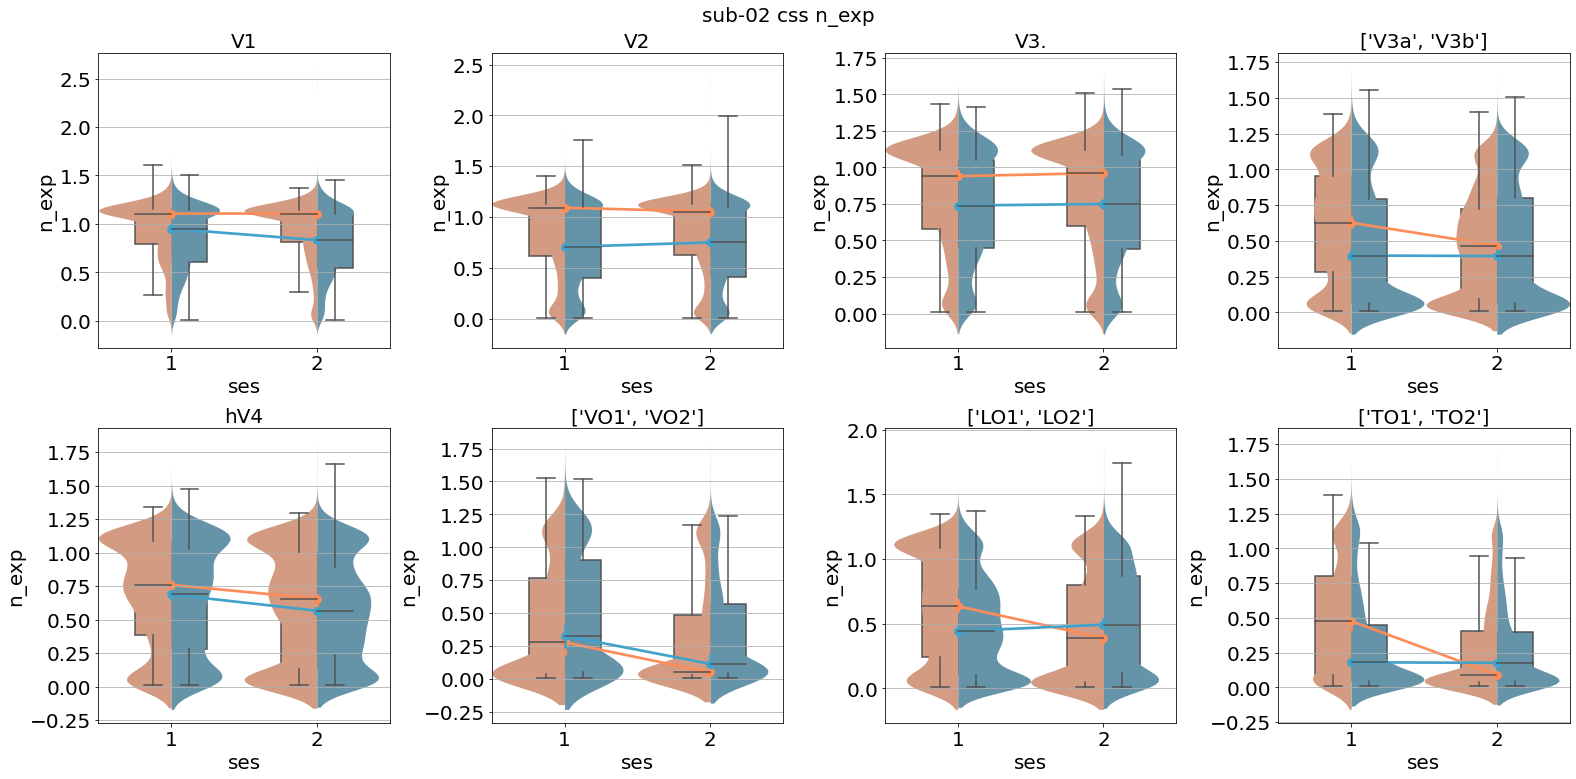

In [65]:
sub = 'sub-02'
m = 'css'
p = 'n_exp'
b14_dict = {
    1:  'V1',   2: 'V2',    3: 'V3',    4: 'hV4',
    5: 'VO1',   6:  'VO2',  7: 'LO1',   8: 'LO2',
    9: 'TO1',   10: 'TO2',  11: 'V3b',  12: 'V3a'}

early_v = ['b14_V1', 'b14_V2', 'b14_V3.']
# later_v = ['b14_V1', 'b14_V2', 'b14_V3.']
roi_list = ['b14_V1', 'b14_V2'] # ['LO1', 'LO2']#['benson', 'b14_V3a', 'b14_V3b']
roi_list = ['V1','V2','V3.',['V3a', 'V3b'], 'hV4',['VO1','VO2'],['LO1','LO2'],['TO1','TO2']]
fig = plt.figure()
nrows = 2
ncols = 4
for i_roi, roi in enumerate(roi_list):
    ax = fig.add_subplot(nrows, ncols, i_roi+1)
    roi_mask = amb_load_roi(sub, roi)
    th = {'min-rsq':.1, 'roi':roi_mask, }
    if m=='gauss':
        th = {**th, 'max-ecc':5}
    if m=='csf':
        th = {**th, 'min-maxC':1}
    this_PD = LE_RE_ses_violin(
        prf_multi=prf_multi[sub], 
        model=m, 
        param=p, do_matched=False, th=th)
    if p in vval_dict.keys():
        plt.gca().set_ylim(vval_dict[p])
    plt.gca().set_title(roi)
plt.gcf().suptitle(f'{sub} {m} {p}')
plt.gcf().set_size_inches(22,11)
plt.gcf().set_tight_layout('tight')
dag_update_fig_fontsize(plt.gcf(), 20)

# 4 x 4 (1 sub at a time) ses, eye kde plots

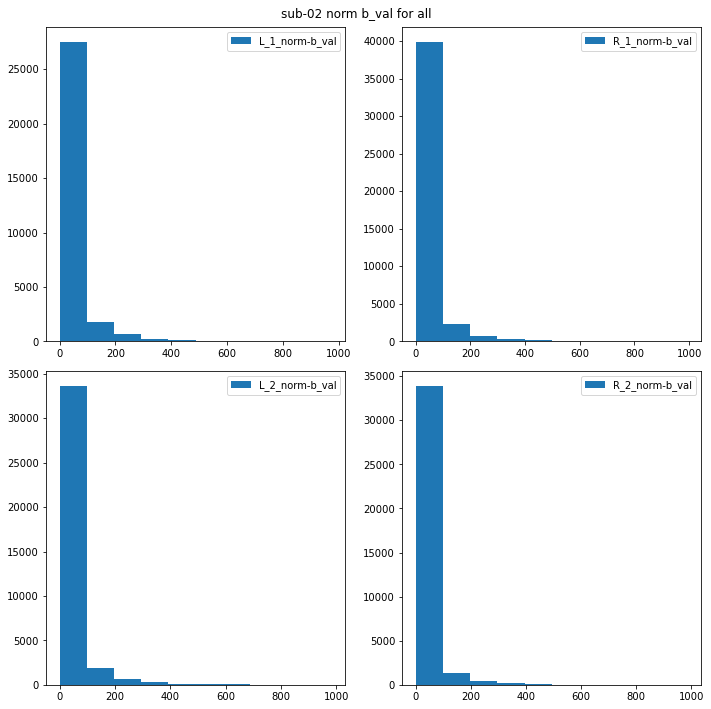

In [95]:
sub = 'sub-02'
m = 'norm'
pid = 'b_val'
roi = 'all'

roi_mask = amb_load_roi(sub, roi)
fig, ax = plt.subplots(2,2)
fig.suptitle(f'{sub} {model} {pid} for {roi}')


for ix,ses in enumerate(['1', '2']):
    for iy,eye in enumerate(['L', 'R']):
        prf_multi[sub].rapid_hist(
            ax=ax[ix,iy],
            px=f'{eye}_{ses}_{m}-{pid}'
            # py=f'{eye}_{ses}_{m}-{pid}'
        )

plt.gcf().set_size_inches(10,10)
plt.gcf().set_tight_layout('tight')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


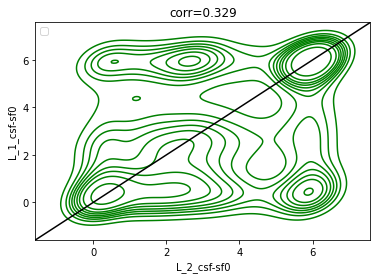

In [92]:
roi_mask = amb_load_roi(sub, 'all')#['b14_V1', 'b14_V2', 'b14_V3.'])
prf_multi[sub].rapid_p_corr(
    ax=plt.gca(),
    py=f'L_1_csf-sf0',
    px=f'L_2_csf-sf0', 
    do_id_line=True, 
    do_kde=True, 
    do_scatter=False, 
    th_plus={'roi':roi_mask, 'L_1_gauss-bound-ecc':[.1,5], 'L_2_gauss-bound-ecc':[.1,5]},
    dot_col='g'
)

# prf_multi[sub].rapid_p_corr(
#     ax=plt.gca(),
#     py=f'L_1_csf-sf0',
#     px=f'L_2_csf-sf0', 
#     do_id_line=True, 
#     do_kde=True, 
#     do_scatter=False, 
#     th_plus={'roi':roi_mask, 'L_1_gauss-bound-ecc':[5,10], 'L_2_gauss-bound-ecc':[5,10]},
#     dot_col='r'
# )

In [100]:
a = {}
for i in a.keys():
    print(i)

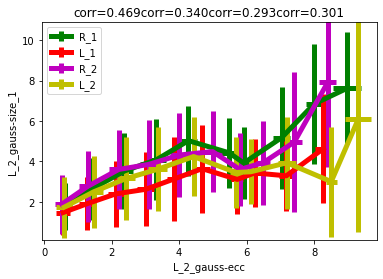

In [59]:

prf_multi[sub].rapid_p_corr(
    ax=plt.gca(),
    py=f'R_1_gauss-size_1',
    px=f'R_1_gauss-ecc', do_id_line=False, do_kde=False, do_scatter=False, th_plus={'roi':roi_mask}, do_line=True, 
    line_col='g',line_label='R_1'
)
prf_multi[sub].rapid_p_corr(
    ax=plt.gca(),
    py=f'L_1_gauss-size_1',
    px=f'L_1_gauss-ecc', do_id_line=False, do_kde=False, do_scatter=False, th_plus={'roi':roi_mask}, do_line=True, 
    line_col='r',line_label='L_1'
)



prf_multi[sub].rapid_p_corr(
    ax=plt.gca(),
    py=f'R_2_gauss-size_1',
    px=f'R_2_gauss-ecc', do_id_line=False, do_kde=False, do_scatter=False, th_plus={'roi':roi_mask}, do_line=True, 
    line_col='m',line_label='R_2'
)
prf_multi[sub].rapid_p_corr(
    ax=plt.gca(),
    py=f'L_2_gauss-size_1',
    px=f'L_2_gauss-ecc', do_id_line=False, do_kde=False, do_scatter=False, th_plus={'roi':roi_mask}, do_line=True, 
    line_col='y',line_label='L_2'
)

plt.legend()
# plt.gcf().set_size_inches(10,10)
# plt.gcf().set_tight_layout('tight')
# plt.gca().set_aspect('equal')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


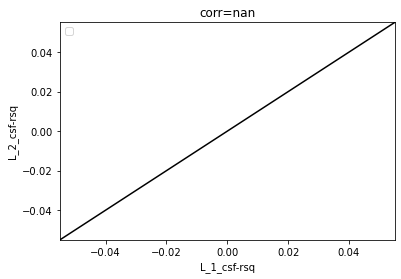

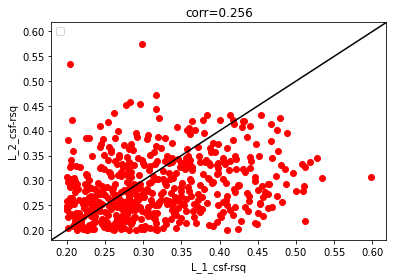

In [261]:

m1 = 'L_1_csf'
m2 = 'L_2_csf'
p1 = 'rsq'
p2 = 'rsq'
th_plus = {
    # f'{m2}-min-maxC': 1    
}
roi ='b14_V1'
for sub in sub_list:
    roi_mask = amb_load_roi(sub, roi)
    th = {
        f'{m1}-min-rsq':.2,
        f'{m2}-min-rsq':.2,        
        'roi' : roi_mask,
        **th_plus,
        
    }
    if p1==p2:
        do_id_line = True
    else:
        do_id_line = False
    
    plt.figure()
    prf_multi[sub].rapid_p_corr(
        f'{m1}-{p1}', f'{m2}-{p2}', do_line=False, th=th,
        do_id_line=do_id_line,do_kde=False, do_scatter=True, dot_col='r'
    )

# np.log10(1e-10000)
# 1e-5 * 10


<AxesSubplot:>

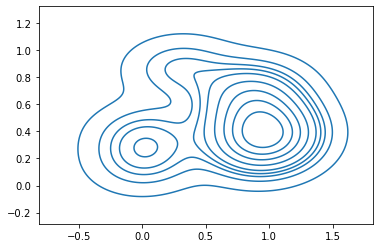

In [249]:
sns.kdeplot(
    np.random.random(10), np.random.random(10)
)

In [222]:
np.log10(10)

1.0

# ROI violin plots

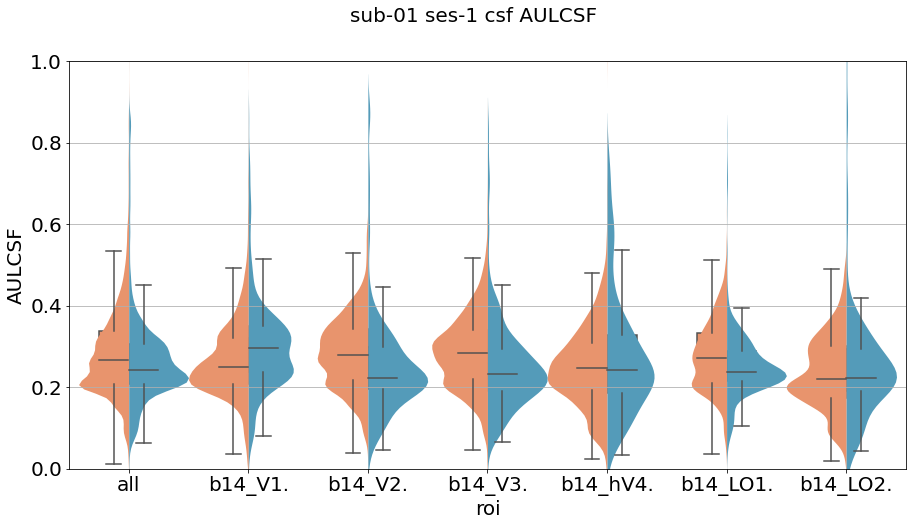

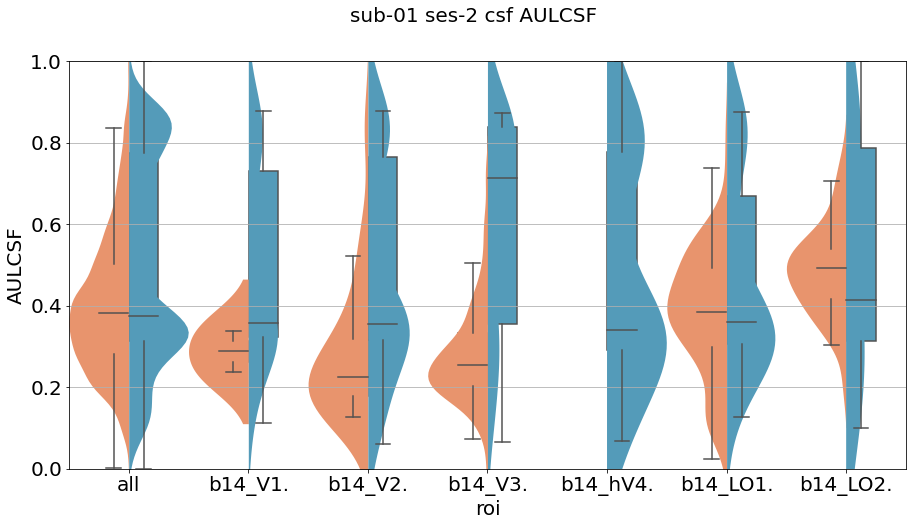

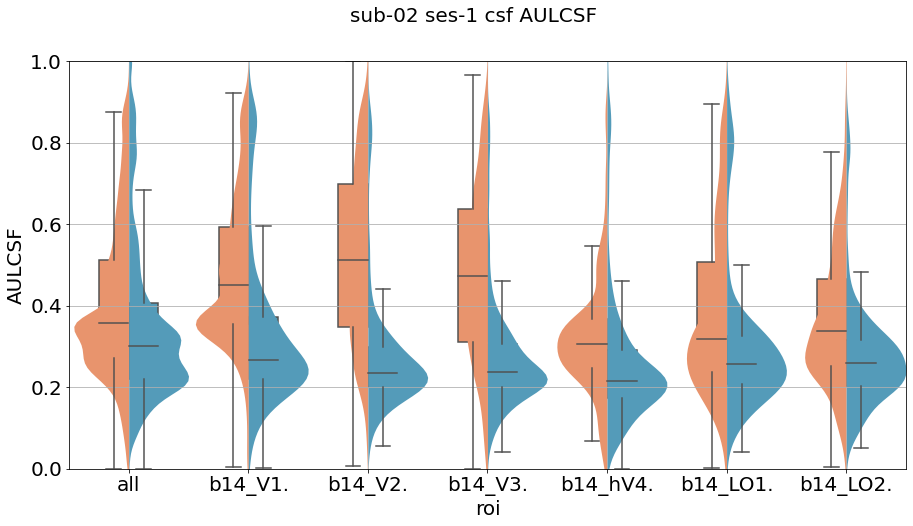

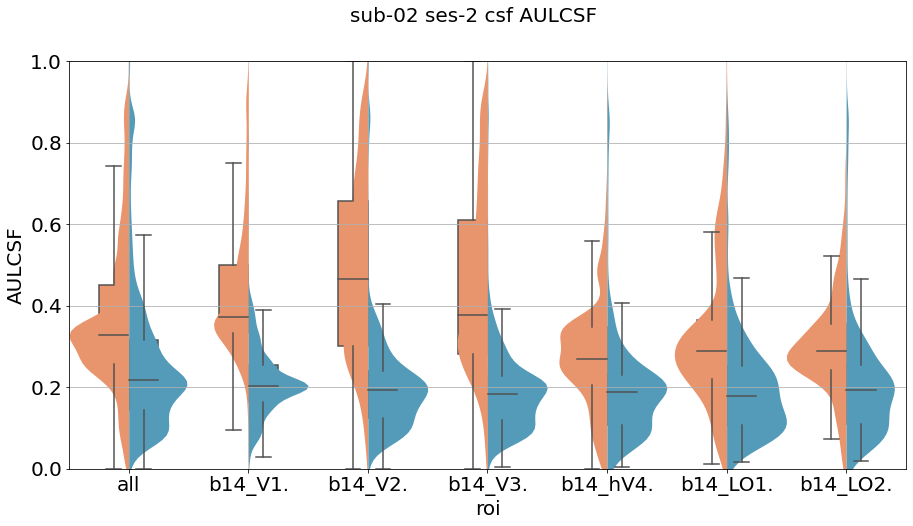

In [66]:
# roi_list = ['all', 'v1custom', 'v2custom', 'v3custom','v3abcustom', 'LOcustom']
def amb_roi_violin(sub, prf_multi, ses, model, param, roi_list, th):        
    p_dict = {}
    p_dict[param] = []
    p_dict['eye'] = []
    p_dict['roi'] = []
    # roi_pval = []
    for roi in roi_list:
        # this_mod_stats = []
        for eye in ['L', 'R']:
            vx_mask  = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].return_vx_mask(th)
            vx_mask &= amb_load_roi(sub, roi)
            this_p = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].pd_params[param][vx_mask].to_numpy()
            p_dict[param].append(this_p)            
            p_dict['roi'].append([roi]*len(this_p))
            p_dict['eye'].append([eye]*len(this_p))
            # this_mod_stats.append(this_p)
        
        # roi_stats = stats.ttest_ind(this_mod_stats[0], this_mod_stats[1])
        # if (roi_stats.pvalue*len(roi_list))<0.01:
        #     roi_pval.append('*')
        # else:
        #     roi_pval.append('')

    for key in p_dict.keys():                                                              
        p_dict[key] = np.concatenate(p_dict[key])                                          
    p_PD = pd.DataFrame(p_dict)                                                            
    sns.violinplot(                                                                        
        x="roi", y=param, hue="eye",                                
        data=p_PD, palette=[plot_cols["LE"], plot_cols["RE"]],                     
        width=1, linewidth=0, split=True, inner=None,)                                     
    sns.boxplot(x="roi", y=param,                                            
                hue="eye", palette=[plot_cols["LE"], plot_cols["RE"]],
                data=p_PD, showfliers = False, width=.5)                               
    # sns.despine(offset=10, trim=True)                                                    
    plt.gca().grid(True, which='both', axis="y")  
    plt.gca().get_legend().remove()
    # plt.legend('off')                                         
    # plt.gca().set_ylim(0,5)                                                               
    # plt.gca().set_title(title)                                                               
    # y_max = plt.gca().get_ylim()[-1]
    # plt.gcf().set_size_inches(10,4)
    dag_update_ax_fontsize(plt.gca(), 15)
    # for i,p in enumerate(roi_pval):
    #     plt.gca().text(i,y_max*.8,p,  color='red', fontsize=40)
    # plt.gca().set_title(f'Rsq for {sub} (fit on AS0, test on AS1,AS2, including scotoma)') 

    return None

roi_list = ['all', 'b14_V1.','b14_V2.','b14_V3.','b14_hV4.', 'b14_LO1.','b14_LO2.']
th = {'min-rsq':.1}


p_list = {
    # 'gauss' : ['ecc',  'size_1', 'rsq'],
    'csf' : ['AULCSF']#, 'sf0', 'maxC', 'sfmax', 'rsq']
    # 'csf': ['size_ratio'],
}    
vval_dict = {
    'pol': [-3.14, 3.14],
    'ecc': [0,5],
    'size_1': [0,8],
    'rsq': [0,1],
    'width_r': [0,3],
    'sf0' : [0,6],
    'maxC': [0, 200],
    'sfmax': [0, 20],
    'AULCSF': [0, 1],
    }
fig_path = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/reports/'
for sub in sub_list:
    for m in p_list.keys():
        for p in p_list[m]:
            for ses in ['1', '2']:
                if m!='csf':
                    th={'min-rsq':.1, 'max-ecc':5}
                else:
                    th={'min-rsq':.1, 'min-maxC':1}
                plt.figure()    
                amb_roi_violin(
                    sub, 
                    prf_multi=prf_multi[sub], 
                    ses=ses,
                    model=m, 
                    param=p, roi_list=roi_list, th=th)
                plt.gcf().suptitle(f'{sub} ses-{ses} {m} {p}')
                if p in vval_dict.keys():
                    plt.gca().set_ylim(vval_dict[p])
                plt.gcf().set_size_inches(15,7.5)
                dag_update_fig_fontsize(plt.gcf(), 20)
                # plt.savefig(opj(fig_path, f'{sub}_violin', f'{sub}_ROI_{ses}_{m}_{p}.svg'))
                # plt.savefig(opj(fig_path, f'{sub}_violin', f'{sub}_ROI_{ses}_{m}_{p}.png'))
                # bloop

# Eccentricity plots

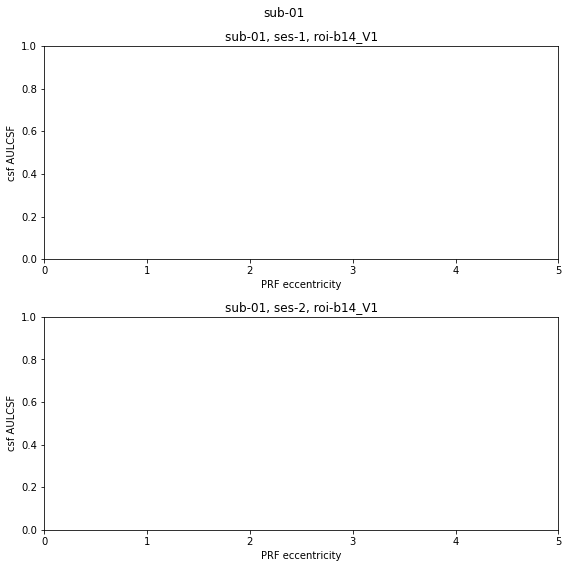

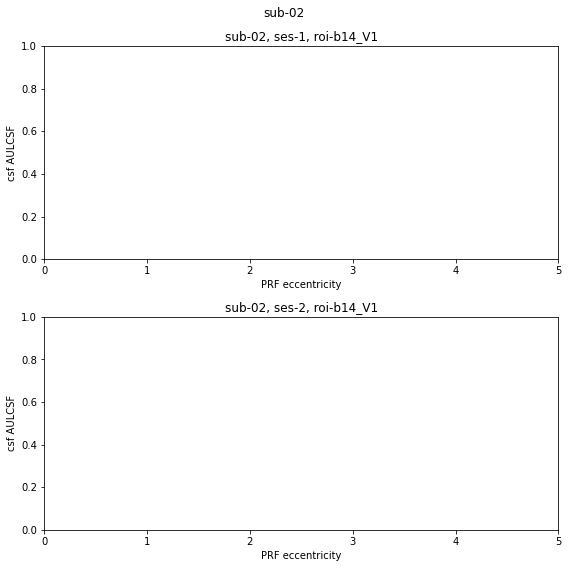

In [68]:
# 1:  'V1',   2: 'V2',    3: 'V3',    4: 'hV4',
# 5: 'VO1',   6:  'VO2',  7: 'LO1',   8: 'LO2',
# 9: 'TO1',   10: 'TO2',  11: 'V3b',  12: 'V3a'}
# ecc plots
m2 = 'csf'
p2 = 'AULCSF'
roi = 'b14_V1' #['b14_V1', 'b14_V2', 'b14_V3.', 'b14_V3a']
xlim = [0,5]
ylim = None#[0,1]


max_ecc = 5
min_rsq = .1
for sub in sub_list:
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(8,8)
    fig.set_tight_layout('tight')
    fig.suptitle(sub)
    roi_mask = amb_load_roi(sub, roi)
    for i_ses,ses in enumerate(['1', '2']):        
        for eye in ['L', 'R']:
            eye_ses = f'{eye}_{ses}'
            th = {
                f'{eye_ses}_gauss-min-rsq':min_rsq,
                f'{eye_ses}_gauss-max-ecc':max_ecc,
                f'{eye_ses}_{m2}-min-rsq':min_rsq,
                'roi':roi_mask,
            }
            try:
                prf_multi[sub].rapid_p_corr(
                    f'{eye_ses}_gauss-ecc',
                    f'{eye_ses}_{m2}-{p2}',
                    th=th, line_col=plot_cols[f'{eye}E'], ax=ax[i_ses],
                    line_label=eye, bins=np.linspace(0,5,6),
                    do_line=True, do_scatter=False, 
                )
            except:
                pass
            ax[i_ses].set_title(f'{sub}, ses-{ses}, roi-{roi}')
            ax[i_ses].set_xlabel(f'PRF eccentricity')
            ax[i_ses].set_ylabel(f'{m2} {p2}')
            ax[i_ses].set_xlim(xlim)
            ax[i_ses].set_ylim(ylim)
        # plt.savefig(opj(fig_path, f'{sub}_simple', f'ecc_{ses}_{m}_{p2}_{roi}.svg'))
        # plt.savefig(opj(fig_path, f'{sub}_simple', f'ecc_{ses}_{m}_{p2}_{roi}.png'))




## Ecc plots by ROI

In [ ]:
# roi_list = ['V1','V2','V3','hV4', 'LO1','LO2']
# # ecc plots
# m2 = 'gauss'
# p2 = 'size_1'
# roi = 'all'
# xlim = [0,5]
# ylim = [0,10]


# max_ecc = 5
# min_rsq = .1
# for sub in ['sub-02']:
#     for i_roi, roi in enumerate(roi_list):
#         fig, ax = plt.subplots(2,1)
#         fig.set_size_inches(8,8)
#         fig.set_tight_layout('tight')
#         fig.suptitle(sub)
#         roi_mask = amb_load_roi(sub, f'b14_{roi}.')
#         this_col = {}
#         # this_col['L'] = dag_get_col_vals(i_roi, 'Reds', vmin=0, vmax=len(roi_list))
#         # this_col['R'] = dag_get_col_vals(i_roi, 'Blues', vmin=0, vmax=len(roi_list))
#         this_col['L'] = plot_cols['LE']
#         this_col['R'] = plot_cols['RE']        
#         for i_ses,ses in enumerate(['1', '2']):        
#             for eye in ['L', 'R']:
#                 eye_ses = f'{eye}_{ses}'
#                 th = {
#                     f'{eye_ses}_gauss-min-rsq':min_rsq,
#                     f'{eye_ses}_gauss-max-ecc':max_ecc,
#                     f'{eye_ses}_{m2}-min-rsq':min_rsq,
#                     'roi':roi_mask,
#                 }

#                 prf_multi[sub].rapid_p_corr(
#                     f'{eye_ses}_gauss-ecc',
#                     f'{eye_ses}_{m2}-{p2}',
#                     th=th, line_col=this_col[eye], ax=ax[i_ses],
#                     line_label=f'{eye}-{roi}',
#                     do_line=True, do_scatter=True, dot_col=this_col[eye] 
#                 )
#                 ax[i_ses].set_title(f'{sub}, ses-{ses}, roi-{roi}')
#                 ax[i_ses].set_xlabel(f'PRF eccentricity')
#                 ax[i_ses].set_ylabel(f'{m2} {p2}')
#                 ax[i_ses].set_xlim(xlim)
#                 ax[i_ses].set_ylim(ylim)
#                 ax[i_ses].legend('')




In [ ]:
# # Ses vs eye ...
# model = 'csf'
# param = f'sf0'
# prf_cols = {
#     'L_1':'#2166ac',
#     'R_1':'#b2182b',
#     'L_2':'#31a354',
#     'R_2':'#8c510a',
# }
# for sub in sub_list:
#     fig, ax = plt.subplots(4,1)
#     fig.set_size_inches(7,12)
#     fig.set_tight_layout('tight')
#     fig.suptitle(sub)
#     for i,ses in enumerate(['1', '2']):
        
#         for eye in ['L', 'R']:
#             eye_ses = f'{eye}_{ses}'
#             vx_mask = prf_multi[sub].return_vx_mask(
#                 {f'{eye_ses}_{model}-min-rsq':.1}
#             )
#             x = prf_multi[sub].prf_obj[f'{eye_ses}_{model}'].pd_params[param][vx_mask]
#             ax[i].hist(x, color=prf_cols[eye_ses], label=eye_ses, alpha=0.6)
#         ax[i].legend()
#         ax[i].set_xlabel(param)


#     for i,eye in enumerate(['L', 'R']):
#         for _,ses in enumerate(['1', '2']):
        
#             eye_ses = f'{eye}_{ses}'
#             vx_mask = prf_multi[sub].return_vx_mask(
#                 {f'{eye_ses}_{model}-min-rsq':.1}
#             )
#             x = prf_multi[sub].prf_obj[f'{eye_ses}_{model}'].pd_params[param][vx_mask]
#             ax[i+2].hist(x, color=prf_cols[eye_ses], label=eye_ses, alpha=0.9)
#         ax[i+2].legend()
#         ax[i+2].set_xlabel(param)



# Time series 

In [112]:
real_tc = {}
pred_tc = {}
pred_tc = {}

for sub in sub_list:
    real_tc[sub] = {}    
    pred_tc[sub] = {}
    pred_tc[sub] = {}

    for ses in ['1', '2']:
        real_tc[sub][ses] = {}    
        pred_tc[sub][ses] = {}
        pred_tc[sub][ses] = {}        

        real_tc[sub][ses] = amb_load_real_tc(sub=sub, task_list=['pRFLE', 'pRFRE', 'CSFLE', 'CSFRE'], ses=f'ses-{ses}')
        pred_tc[sub][ses] = amb_load_pred_tc(sub=sub, task_list=['pRFLE', 'pRFRE'], model_list='gauss', ses=f'ses-{ses}')
        pred_tc[sub][ses] |= amb_load_pred_tc(sub=sub, task_list=['CSFRE', 'CSFLE'], model_list='csf', ses=f'ses-{ses}')


In [201]:
sub = 'sub-02'
ses = '1'
eye = 'L'
m = 'csf'
task = f'CSF{eye}E'.upper()


this_amb_plotter = AmbPlotter(
    sub=sub, 
    real_tc=real_tc[sub][ses][task], 
    csf_params = prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].prf_params_np
)

all_good_fits  = np.where(this_amb_plotter.return_vx_mask({'min-rsq':.1,  'min-maxC':1}))[0]

In [202]:
this_amb_plotter.pd_params['log10_sfmax'][all_good_fits].min()

-0.32845699474073164

0.0
0.14770620424146041
0.0
0.2545230232345526
0.0
0.9718060670575384
0.0
0.6631510551931041
0.0
0.37061082458717926
0.0
0.5816446287558745
0.0
0.6677986170196837
0.0
0.21770603739092131
0.0
0.48193935901788676
0.0
0.5220511123199921


<Figure size 432x288 with 0 Axes>

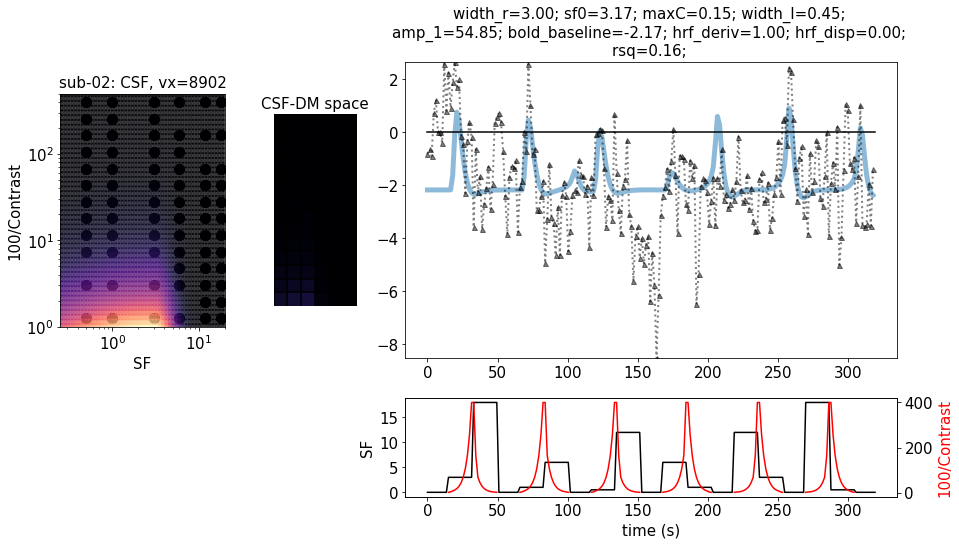

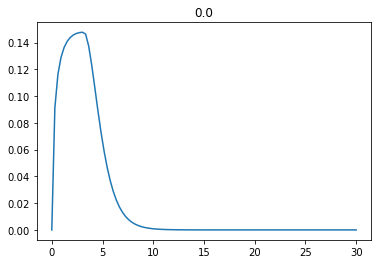

<Figure size 432x288 with 0 Axes>

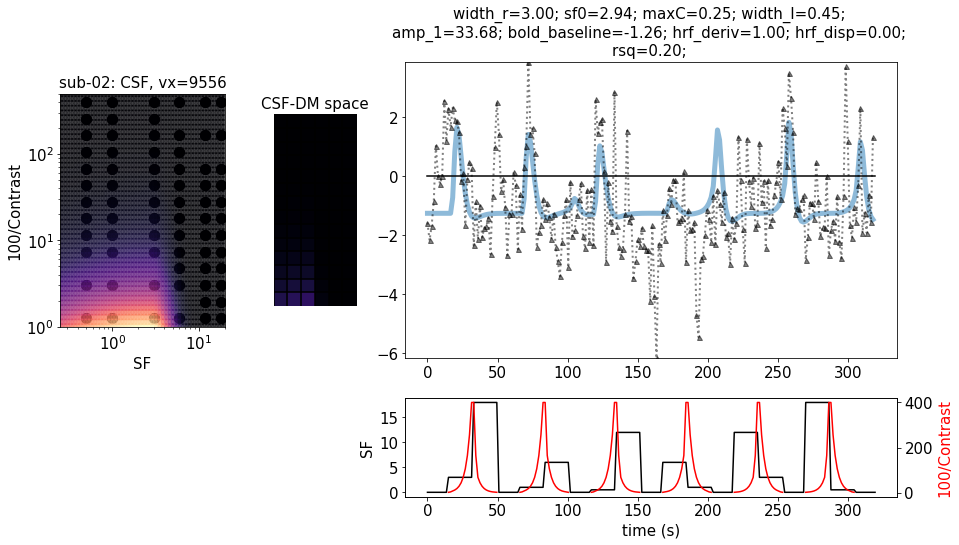

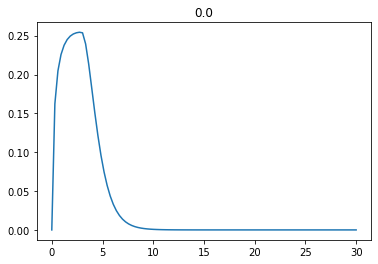

<Figure size 432x288 with 0 Axes>

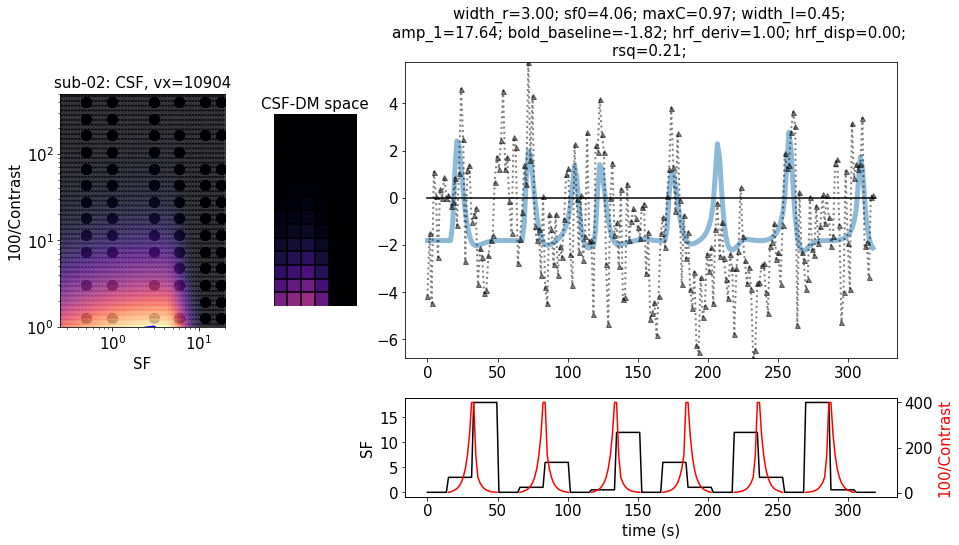

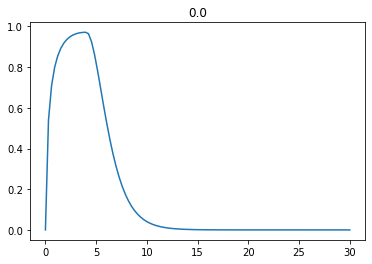

<Figure size 432x288 with 0 Axes>

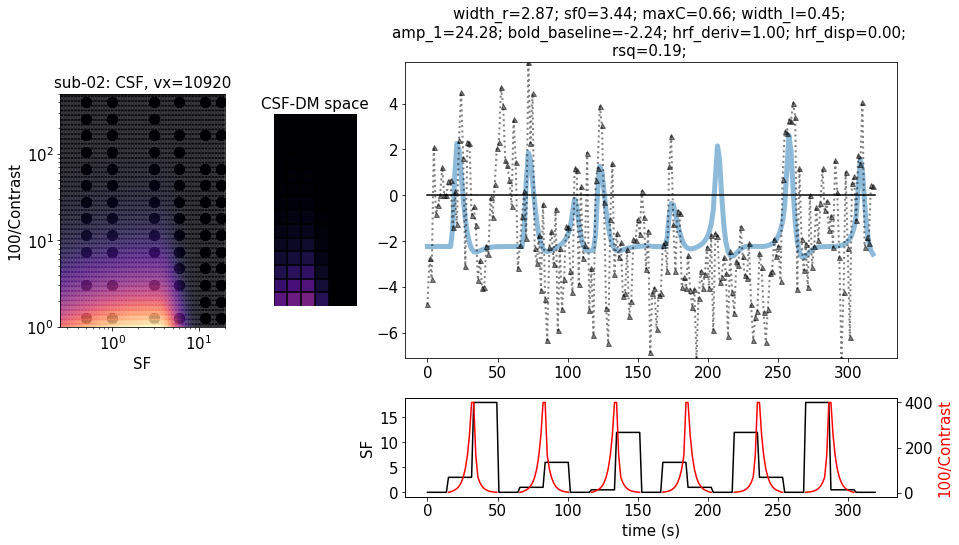

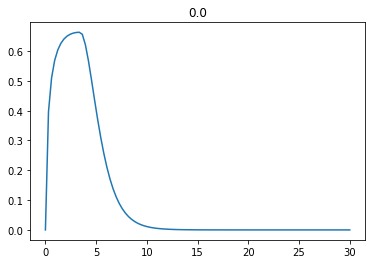

<Figure size 432x288 with 0 Axes>

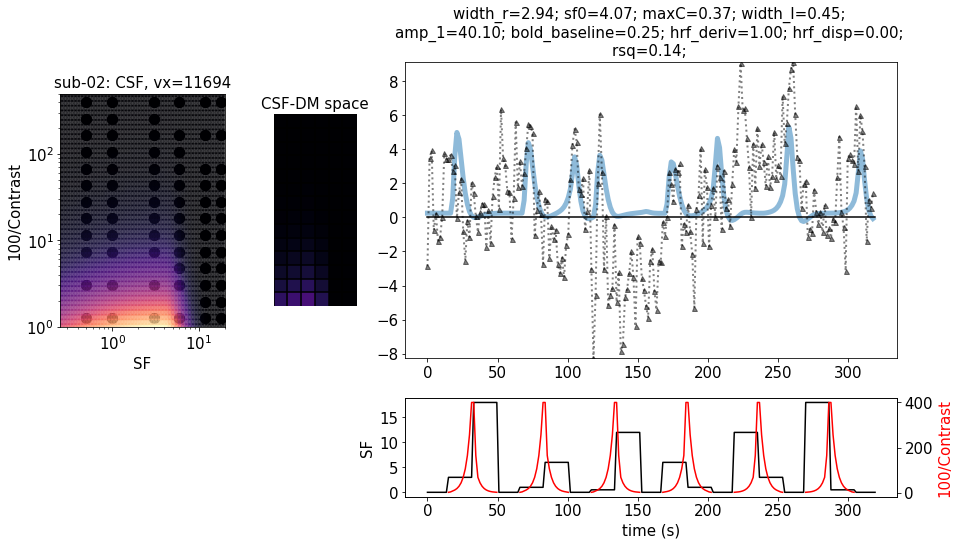

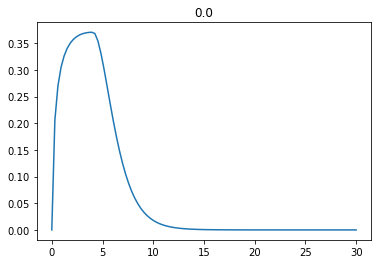

<Figure size 432x288 with 0 Axes>

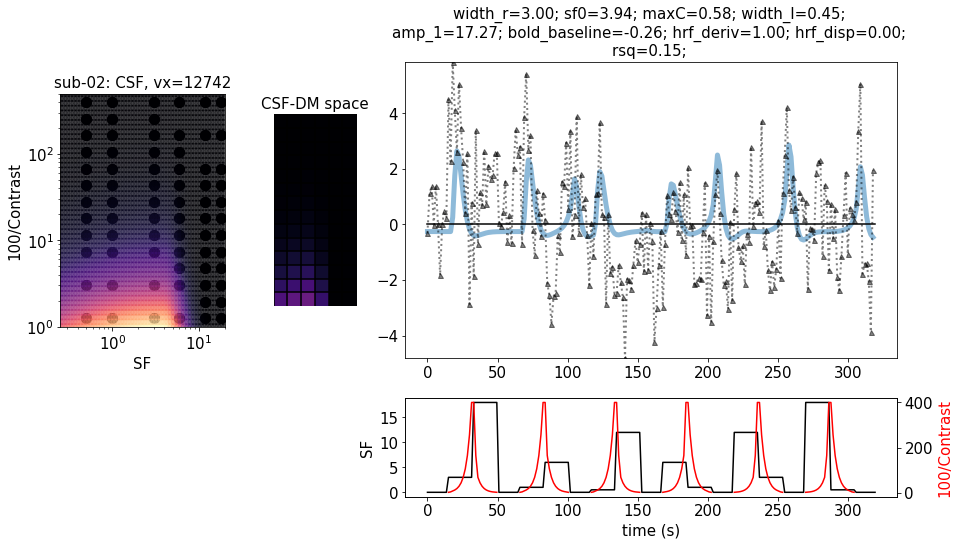

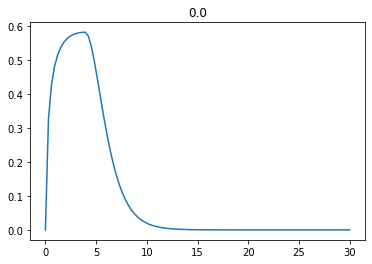

<Figure size 432x288 with 0 Axes>

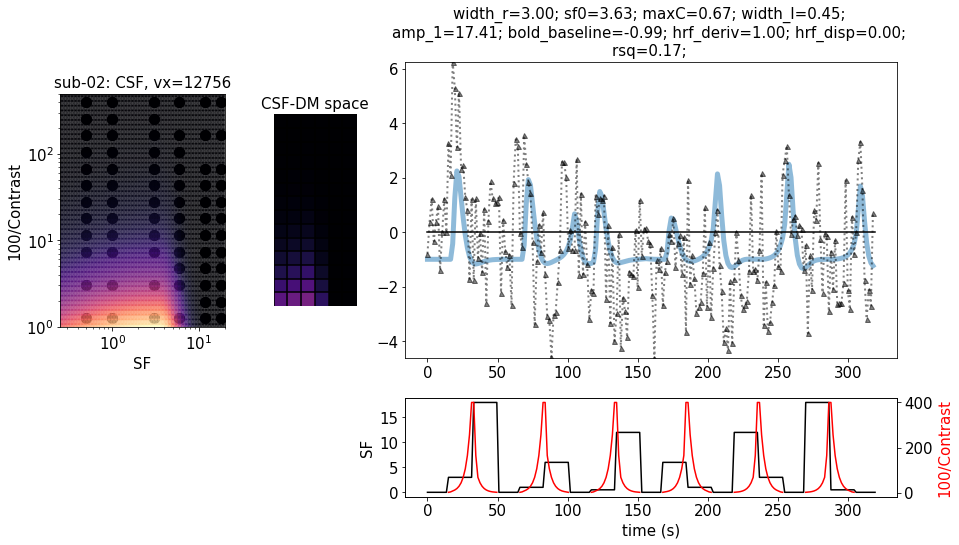

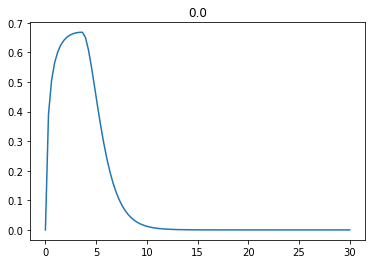

<Figure size 432x288 with 0 Axes>

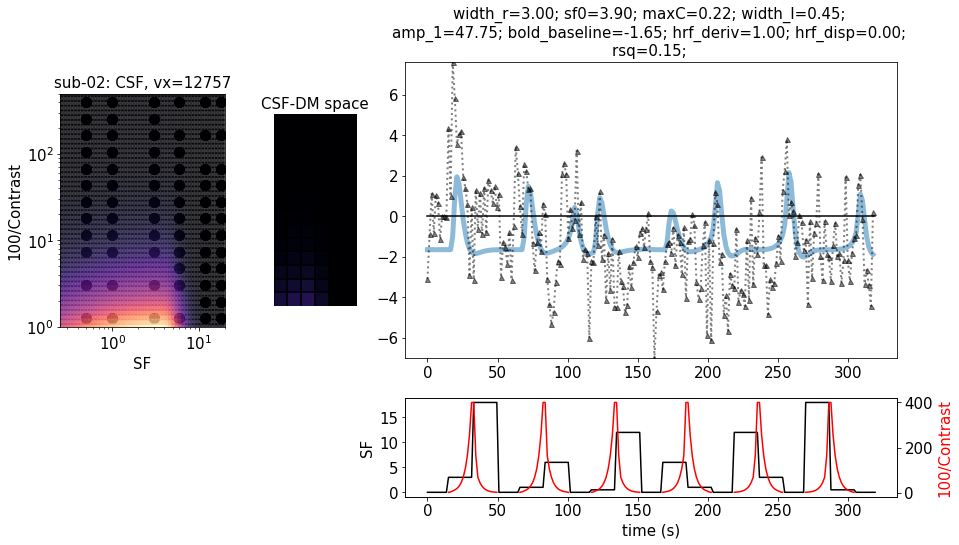

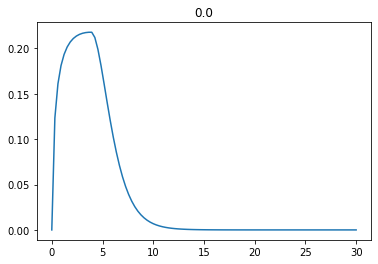

<Figure size 432x288 with 0 Axes>

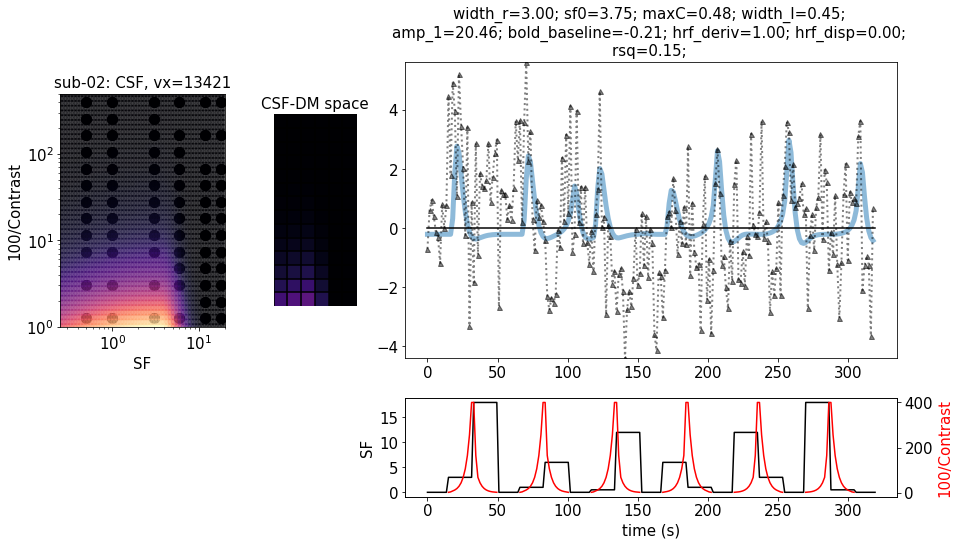

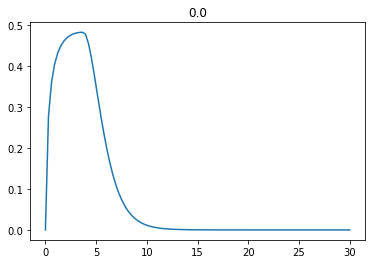

<Figure size 432x288 with 0 Axes>

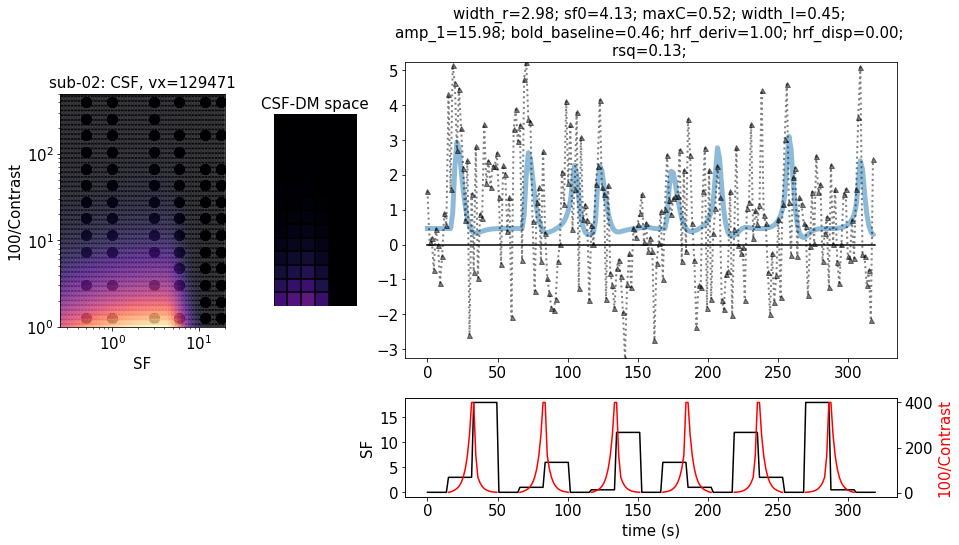

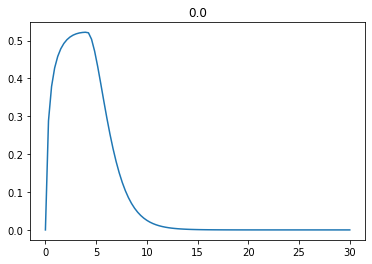

In [167]:
for id in all_good_fits[:10]:
    plt.figure()

    this_amb_plotter.csf_tc_plot(id)
    print(this_amb_plotter.pd_params['sfmax'][id])
    print(this_amb_plotter.pd_params['maxC'][id])
    plt.figure()
    SFs = np.linspace(0,30,100),
    this_curve = ncsf_curve(
        SFs = SFs,
        width_r=this_amb_plotter.pd_params['width_r'][id],
        sf0=this_amb_plotter.pd_params['sf0'][id],
        maxC=this_amb_plotter.pd_params['maxC'][id],
        width_l=this_amb_plotter.pd_params['width_l'][id],
        apply_0_th=False,
    )
    plt.plot(
        np.squeeze(SFs),
        10**np.squeeze(this_curve),
    )
    plt.title(this_amb_plotter.pd_params['sfmax'][id])

0.0

In [ ]:
# MOVIE

m = 'csf'
all_good_fits  = np.where(prf_multi[sub].return_vx_mask({'all-min-rsq':.4}))[0]
print(all_good_fits)
id = all_good_fits[0]
movie_folder = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/reports/movie_eg'
for eye in ['L', 'R']:
    task = f'{model}{eye}E'.upper()

    amb_plotter = AmbPlotter(
        sub=sub, 
        real_tc=real_tc[sub][ses][task], 
        csf_params = prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].prf_params_np
    )


    save_name = opj(movie_folder, f'./csf_tc_{sub}-{eye}-vx{id}')
    if not os.path.exists(save_name):
        os.mkdir(save_name)
    i_0 = 0
    i_m1 = 214
    i_step = 1
    i_fig = 0
    for i in range(i_0,i_m1,i_step):
        plt.figure()
        amb_plotter.csf_tc_plot(id, i)
        fig = plt.gcf()
        fig.savefig(f"{save_name}/file{i_fig:03}.png")
        plt.close(fig)
        print(i_fig)
        i_fig += 1

    # ffmpeg_dir = "/home/**your_name**/.conda/envs/**env_name**/bin/ffmpeg"
    ffmpeg_dir = '~/.conda/envs/dag_atlas/bin/ffmpeg'
    # Select the directory with all of the images, and file name pattern
    # >> -r 15 controls frame rate, can be faster or slower 
    os.system(f"{ffmpeg_dir} -r 5 -i {save_name}/file%03d.png -codec mpeg4 -y {save_name}_movie.mp4")
    os.system(f"rm -R {save_name}")


# 4 x 4 scatter [LE-1 vs RE-1], [LE-2 vs RE-2], [LE-1 ]


In [ ]:
# 4 x4 scatter 


In [ ]:
roi = 'b14_V2'#, 'V1_exvivo', 'V2_exvivo', 'MT_exvivo']

csf_th = {'min-rsq':.1}
for sub in sub_list:
    for ses in ['1', '2']:
        roi_mask = amb_load_roi(sub, roi)
        plt.figure()
        plt.title(f'{sub}-{ses}-N-{roi}')
        for eye in ['L', 'R']:
            prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].rsq_w_mean(
                ['width_r','sf0','maxC','width_l'], 
                th={**csf_th, 'roi':roi_mask})    
        for eye in ['L', 'R']:
            n_log_csf = ncsf_curve(
                    SFs, 
                    prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].wm_param['width_r'], 
                    prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].wm_param['sf0'], 
                    prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].wm_param['maxC'], 
                    prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].wm_param['width_l']    
                    )
            if eye=='L':
                # this_cmap = dag_get_cmap('Reds')
                # col = this_cmap(rsq_th+.2)
                col='r'
            else:
                # this_cmap = dag_get_cmap('Blues')
                # col = this_cmap(rsq_th+.1)
                col='b'
            plt.plot(
                np.log10(SFs), 
                n_log_csf, 
                color=col, 
                marker='*', 
                label=f'{eye}')
            # Also plot max
            ylim = (0,2.5)
            this_log_sf0 = np.log10(prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].wm_param['sf0'])
            plt.plot((this_log_sf0,this_log_sf0), ylim, color=col)

        plt.legend()        

In [ ]:
sub = 'sub-01'
this_PD = LE_RE_ses_violin(
    prf_multi=prf_multi[sub], 
    model='gauss', 
    param='rsq', do_matched=True, th={'all-min-rsq':.2})

In [ ]:
this_PD
from statsmodels.stats.anova import AnovaRM
aovrm2way = AnovaRM(this_PD, 'rsq', 'vx_id', within=['eye', 'ses'])
results = aovrm2way.fit()

In [ ]:
print(results)

In [ ]:


def LE_RE_ses_pd(prf_multi, model, param, th=None, do_plot=True, matched=True):        
    if th is None:
        th = {'all-min-rsq':.1}
    vx_mask = prf_multi.return_vx_mask(th)
    
    p_dict = {}
    p_dict[param] = []
    p_dict['eye'] = []
    p_dict['ses'] = []
    p_dict['vx_id'] = []

    # p_dict['model'] = []
    for eye in ['L', 'R']:
        for ses in ['1', '2']:
            # vx_mask = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].return_vx_mask(th)
            this_p = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].pd_params[param][vx_mask]
            # this_p = np.random.rand(len(this_p))
            p_dict[param].append(this_p)
            # this_
            p_dict['eye'].append([eye]*len(this_p))
            p_dict['ses'].append([ses]*len(this_p))
            p_dict['vx_id'].append(np.arange(len(this_p)))

    for key in p_dict.keys():                                                              
        p_dict[key] = np.concatenate(p_dict[key])                                          
    p_PD = pd.DataFrame(p_dict)    
    p_PD['eye'] = pd.Categorical(p_PD['eye'])
    p_PD['ses'] = pd.Categorical(p_PD['ses'])

    return p_PD



In [ ]:
prf_multi.id_list

In [ ]:
roi = 'all'
roi_mask = amb_load_roi(sub, roi)
model = 'csf'
for param in ['sf0', 'maxC', 'width_r', 'sfmax', 'rsq']:
    formula = f'{param} ~ C(eye) + C(ses) + C(eye):C(ses)'
    # param = 'sfmax'
    this_PD = LE_RE_ses_pd(
        prf_multi=prf_multi, 
        model='csf', 
        param=param, th={'all-min-rsq':.1, 'roi':roi_mask})
    model = ols(formula, data=this_PD).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(param)
    print(model._results.params)
    print(anova_table)
    print('')
    plt.figure()
    # # Plotting box plots
    # sns.boxplot(x='eye', y=param, hue='ses', data=this_PD)
    # plt.title(f'{param} by Eye and Treatment')
    # plt.xlabel('Eye')
    # plt.ylabel(param)
    # plt.show()

    # Plotting interaction plots
    sns.pointplot(x='eye', y=param, hue='ses', data=this_PD)
    plt.title('Interaction Plot: Visual Acuity by Eye and Treatment')
    plt.xlabel('Eye')
    plt.ylabel(param)
    plt.show()    


In [ ]:
roi = 'all'
roi_mask = amb_load_roi(sub, roi)
model = 'prf'
for param in ['ecc', 'rsq', 'rsq']:
    formula = f'{param} ~ C(eye) + C(ses) + C(eye):C(ses)'
    # param = 'sfmax'
    this_PD = LE_RE_ses_pd(
        prf_multi=prf_multi, 
        model=model, 
        param=param, th={'all-min-rsq':.1,'all-max-ecc':5, 'roi':roi_mask})
    model = ols(formula, data=this_PD).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(param)
    print(model._results.params)
    print(anova_table)
    print('')
    plt.figure()
    # # Plotting box plots
    # sns.boxplot(x='eye', y=param, hue='ses', data=this_PD)
    # plt.title(f'{param} by Eye and Treatment')
    # plt.xlabel('Eye')
    # plt.ylabel(param)
    # plt.show()

    # Plotting interaction plots
    sns.pointplot(x='eye', y=param, hue='ses', data=this_PD)
    plt.title('Interaction Plot: Visual Acuity by Eye and Treatment')
    plt.xlabel('Eye')
    plt.ylabel(param)
    plt.show()    


In [ ]:
# model._results.__dict__.keys()


In [ ]:




# this_PD = LE_RE_ses_violin(
#     prf_multi=prf_multi, 
#     model='csf', 
#     param='sfmax', th={'min-rsq':.1}, do_plot = False)
# # Performing two-way ANOVA
# model = ols(
#     'height ~ C(Fertilizer) + C(Watering) +\
#     C(Fertilizer):C(Watering)', data=df).fit()
# sm.stats.anova_lm(model, typ=2)

In [ ]:
# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)






In [ ]:
prf_multi.id_list

In [ ]:
sub_list = ['sub-01', 'sub-02']
roi_fit = 'all'


In [ ]:
# prf_data = {}
# csf_data = {}
# real_tc = {}
# pred_tc = {}
# pred_tc = {}
prf_objs = {}
all_prf_objs = {}
for sub in sub_list:

    # LOAD USEFUL INFORMATION
    prf_data = amb_load_prf_params(
        sub=sub,
        task_list=['pRFLE', 'pRFRE'],
        model_list='gauss',
        roi_fit=roi_fit,            
    )

    csf_data = amb_load_prf_params(
        sub=sub,
        task_list=['CSFLE', 'CSFRE'],
        model_list='csf',
        roi_fit=roi_fit,            
    )

    # real_tc[sub] = amb_load_real_tc(sub=sub, task_list=['pRFLE', 'pRFRE', 'CSFLE', 'CSFRE'])
    # pred_tc[sub] = amb_load_pred_tc(sub=sub, task_list=['pRFLE', 'pRFRE'], model_list='gauss')
    # pred_tc[sub] |= amb_load_pred_tc(sub=sub, task_list=['CSFRE', 'CSFLE'], model_list='csf')

    # Enter into prf objects:
    prf_obj_list = []
    prf_id_list = []
    prf_obj = {}
    model = 'gauss'
    for task in ['pRFLE', 'pRFRE']:    
        prf_obj[task] = {}    
        prf_obj[task][model] = Prf1T1M(prf_data[task][model], model)
        prf_obj_list.append(Prf1T1M(prf_data[task][model], model))
        prf_id_list.append(task)

    model = 'csf'
    for task in ['CSFLE', 'CSFRE']:    
        prf_obj[task] = {}    
        prf_obj[task][model] = Prf1T1M(csf_data[task][model], model)

        prf_obj_list.append(Prf1T1M(csf_data[task][model], model, fixed_hrf=True))
        prf_id_list.append(task)

    prf_objs[sub] = prf_obj
    all_prf_objs[sub] = PrfMulti(prf_obj_list, prf_id_list)

In [ ]:

def mini_show_csf_param(param, min_rsq, bins):
    for sub in sub_list:
        plt.figure()
        all_prf_objs[sub].rapid_hist(
            f'CSFLE-{param}', label=f'LE-{param}', color=plot_cols['LE'], bins=bins,ax=plt.gca(),
            th={'CSFLE-min-rsq':min_rsq})
        all_prf_objs[sub].rapid_hist(
            f'CSFRE-{param}', label=f'RE-{param}', color=plot_cols['RE'], bins=bins,ax=plt.gca(),
            th={'CSFRE-min-rsq':min_rsq})
        plt.title(sub)

        plt.figure()
        all_prf_objs[sub].rapid_p_corr(
            f'CSFLE-{param}', f'CSFRE-{param}', ax=plt.gca(),do_line=True,do_id_line=True,
            th={'CSFLE-min-rsq':min_rsq, 'CSFRE-min-rsq':min_rsq})
        plt.title(sub)


In [ ]:
min_rsq = .2
bins = np.linspace(0,6,10)
param = 'sf0'
mini_show_csf_param(param, min_rsq, bins)

In [ ]:
min_rsq = .1
bins = np.linspace(0,6,20)
param = 'width_r'
mini_show_csf_param(param, min_rsq, bins)

In [ ]:
# prf_obj['pRFLE']['gauss'].rapid_p_corr('ecc', 'size_1', th={'min-rsq':.1, 'max-ecc':5}, do_line=True)

# plt.figure()
# prf_obj['pRFRE']['gauss'].rapid_p_corr('ecc', 'size_1', th={'min-rsq':.1, 'max-ecc':5}, do_line=True)

# plt.figure()

all_prf_obj2.rapid_p_corr(
    'pRFLE-ecc', 'pRFLE-size_1', do_line=True, do_scatter=False, line_label='LE',
    th={'pRFLE-min-rsq':.1, 'pRFLE-max-ecc':5,})

all_prf_obj2.rapid_p_corr(    
    'pRFRE-ecc', 'pRFRE-size_1',ax=plt.gca(), do_line=True, do_scatter=False, line_col='b', line_label='RE',
    th={'pRFRE-min-rsq':.1, 'pRFRE-max-ecc':5,})

In [ ]:
# csf_tc_plotter(
#     real_tc=real_tc['CSFLE'], 
#     pred_tc=pred_tc['CSFLE'], 
#     params=prf_obj['CSFLE']['csf'].prf_params_np, idx=[8,10])
from amb_scripts.plot_csfv3 import *


In [ ]:
amb_plotter = AmbPlotter(
    sub=sub, 
    real_tc=real_tc['CSFLE'],
    csf_params = csf_data['CSFLE']['csf'],
    
    )

In [ ]:
amb_plotter.csf_tc_plot(idx=8, time_pt=None)

In [ ]:
np.where(prf_obj['CSFLE']['csf'].prf_params_np[:,-1]>0.1)

In [ ]:
# # # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFLE-hrf_deriv', alpha=0.5)
# # # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFRE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFRE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFLE-hrf_deriv', alpha=0.5)

# all_prf_obj.rapid_p_corr(
#     'CSFLE-rsq',
#     'CSFRE-rsq', 
#     th={'CSFLE-min-rsq':.1, 'CSFRE-min-rsq':.1}, 
#     do_line=True, line_col='r', dot_col='k', dot_alpha=.5)

In [ ]:
# prf_dE = Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['pRFRE']['gauss'], id1='prfLE', id2='prfRE')
# csf_dE = Prf1T1Mx2(prf_obj['CSFLE']['csf'], prf_obj['CSFRE']['csf'], id1='csfLE', id2='csfRE')
# le_dT =  Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['CSFLE']['csf'], id1='prfLE', id2='csfLE')
# re_dT =  Prf1T1Mx2(prf_obj['pRFRE']['gauss'], prf_obj['CSFRE']['csf'], id1='prfRE', id2='csfRE')

In [ ]:
# # prf_dE.rapid_p_corr(
# #     'prfLE-hrf_deriv',
# #     'prfRE-hrf_deriv'
# # )
# # plt.figure()
# # csf_dE.rapid_p_corr(
# #     'csfLE-hrf_deriv',
# #     'csfRE-hrf_deriv'
# # )

# # plt.figure()
# # le_dT.rapid_p_corr(
# #     'csfLE-hrf_deriv',
# #     'prfLE-hrf_deriv'
# # )

# roi = amb_load_roi(sub, 'demo-5000000')
# plt.figure()
# re_dT.rapid_p_corr(
#     'prfRE-hrf_deriv',
#     'csfRE-hrf_deriv',
#     th={'all-min-rsq':.3, 'roi':roi},
# )

In [ ]:
fs = FSMaker(sub, fs_dir)
model = 'gauss'
# POLAR 
for task in task_list:
    # fs.add_surface(
    #     data = prf_obj[task][model].pd_params['pol'],
    #     surf_name = f'{sub}-{task}-{model}-pol',    
    #     vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    #     data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
    #     cmap = 'hsv_hsv', # using hsv for polar angle, can use something else...
    # )
    # POL CLOCK
    clock_val = dag_pol_to_clock(prf_obj[task][model].pd_params['pol'])
    fs.add_surface(
        data = clock_val,
        surf_name = f'{sub}-{task}-{model}-pol-clock',    
        vmin = 0, vmax=12, # min and max values of polar anlge 
        data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
        cmap = 'magma_viridis', # using hsv for polar angle, can use something else...
        cmap_nsteps=20
    )    
# model = 'csf'
# for task in ['CSFLE', 'CSFRE']:
#     fs.add_surface(
#         data = clock_val,
#         surf_name = f'{sub}-{task}-{model}-pol-clock',    
#         vmin = 0, vmax=12, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'twilight', # using hsv for polar angle, can use something else...
#         cmap_nsteps=20
#     )        


# # d_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['d_val'],
#         surf_name = f'{sub}-{task}-{model}-d_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'jet', # using hsv for polar angle, can use something else...
#     )


# # b_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['b_val'],
#         surf_name = f'{sub}-{task}-{model}-b_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'viridis', # using hsv for polar angle, can use something else...
#     )


# size_1
# model = 'gauss'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['size_1'],
#         surf_name = f'{sub}-{task}-{model}-size_1',    
#         vmin = 0, vmax=10, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'ecc', # using hsv for polar angle, can use something else...
#     )


In [ ]:
fs.open_fs_surface(
    fs.surf_list, 
    mesh='inflated', 
    # roi_list=['v1custom', 'v2custom', 'v3custom', 'LOcustom']
    )

In [ ]:
dag_stack_cmaps(['magma','viridis'])#, save_cmap=True)#, 'magma_r'])
# a = dag_get_cmap('viridis_magmarev')

# plt.imshow(
#     np.linspace(0,1,1000)*np.ones((100,1000)),
#     cmap=a, vmin=0, vmax=1)

# dag_make_custom_cmap(
#     ['green', 'green'], cmap_name='blah', save_cmap=True
# )


In [ ]:
# dag_get_cmap('blah')
dag_stack_cmaps(['plasma_r'])

***